In [1]:
import os
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms

from models.modeling import VisionTransformer, CONFIGS

# Load Your Trained Model
config = CONFIGS["ViT-B_16"]  # Ensure this matches your model type
num_classes = 3  # Your dataset has 3 classes: normal, pain, tickle
model_path = "output/test_checkpoint.bin"  # Change if your model is saved under a different name

# Initialize model
model = VisionTransformer(config, num_classes=num_classes, zero_head=True, img_size=224, vis=True)

# Load trained weights
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    print("✅ Model loaded successfully!")
else:
    raise FileNotFoundError(f"❌ Model checkpoint not found at {model_path}")

model.eval()

# Define Image Transformations (Same as Training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Load an Image from Your Dataset
test_img_path = r"C:\Users\avs20\Documents\GitHub\ViT-EmotionClassificationPytorch\data\normal\normal_0003.bmp"  # Change to a real image path
if not os.path.exists(test_img_path):
    raise FileNotFoundError(f"❌ Test image not found: {test_img_path}")

im = Image.open(test_img_path)
x = transform(im).unsqueeze(0)

# Forward Pass Through Model
with torch.no_grad():
    logits, att_mat = model(x)

# Compute Attention Matrices
att_mat = torch.stack(att_mat).squeeze(1)
att_mat = torch.mean(att_mat, dim=1)  # Average over heads

# Add identity matrix to account for residual connections
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Compute Joint Attention
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]
for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

# Extract the Final Attention Map
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
result = (mask * np.array(im)).astype("uint8")

# Display Image & Attention Map
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
ax1.set_title('Original Image')
ax2.set_title('Attention Map')

ax1.imshow(im)
ax2.imshow(result)

plt.show()

# Get Prediction
probs = torch.nn.Softmax(dim=-1)(logits)
predicted_class = torch.argmax(probs, dim=-1).item()

# Class Mapping (Adjust as Needed)
class_labels = {0: "Normal", 1: "Pain", 2: "Tickle"}

print(f"Prediction: {class_labels[predicted_class]} (Confidence: {probs[0, predicted_class]:.5f})")


✅ Model loaded successfully!


ValueError: too many values to unpack (expected 2)

In [ ]:
import os
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms

from models.modeling import VisionTransformer, CONFIGS

# Load Your Trained Model
config = CONFIGS["ViT-B_16"]  # Ensure this matches your model type
num_classes = 3  # Your dataset has 3 classes: normal, pain, tickle
model_path = "output/test_checkpoint.bin"  # Change if necessary

# Initialize model
model = VisionTransformer(config, num_classes=num_classes, zero_head=True, img_size=224, vis=True)

# Load trained weights
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    print("✅ Model loaded successfully!")
else:
    raise FileNotFoundError(f"❌ Model checkpoint not found at {model_path}")

model.eval()

# Define Image Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Load an Image from Your Dataset
test_img_path = r"C:\Users\avs20\Documents\GitHub\ViT-EmotionClassificationPytorch\data\normal\normal_0003.bmp"  # Change to a real image path
if not os.path.exists(test_img_path):
    raise FileNotFoundError(f"❌ Test image not found: {test_img_path}")

im = Image.open(test_img_path).convert("RGB")  # Ensure RGB format
x = transform(im).unsqueeze(0)

# Forward Pass Through Model
with torch.no_grad():
    logits, att_mat = model(x)

# Compute Attention Matrices
att_mat = torch.stack(att_mat).squeeze(1)
att_mat = torch.mean(att_mat, dim=1)  # Average over heads

# Add identity matrix for residual connections
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Compute Joint Attention
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]
for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

# Extract Final Attention Map
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()

# Resize the attention map to match the image size
mask = cv2.resize(mask, im.size)

# Normalize the heatmap
mask = (mask - mask.min()) / (mask.max() - mask.min())

# Apply the Viridis colormap
heatmap = plt.cm.viridis(mask)[:, :, :3]  # Remove alpha channel

# Convert the original image to NumPy array
image_np = np.array(im) / 255.0  # Normalize to [0,1] for blending

# Blend heatmap and original image
alpha = 0.5  # Transparency level
overlay = (1 - alpha) * image_np + alpha * heatmap

# Display the results
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))

ax1.set_title('Original Image')
ax1.imshow(im)

ax2.set_title('Attention Map (Viridis Overlay)')
ax2.imshow(overlay)

plt.show()

# Get Prediction
probs = torch.nn.Softmax(dim=-1)(logits)
predicted_class = torch.argmax(probs, dim=-1).item()

# Class Mapping (Adjust as Needed)
class_labels = {0: "Normal", 1: "Pain", 2: "Tickle"}

print(f"Prediction: {class_labels[predicted_class]} (Confidence: {probs[0, predicted_class]:.5f})")


✅ Model loaded successfully!


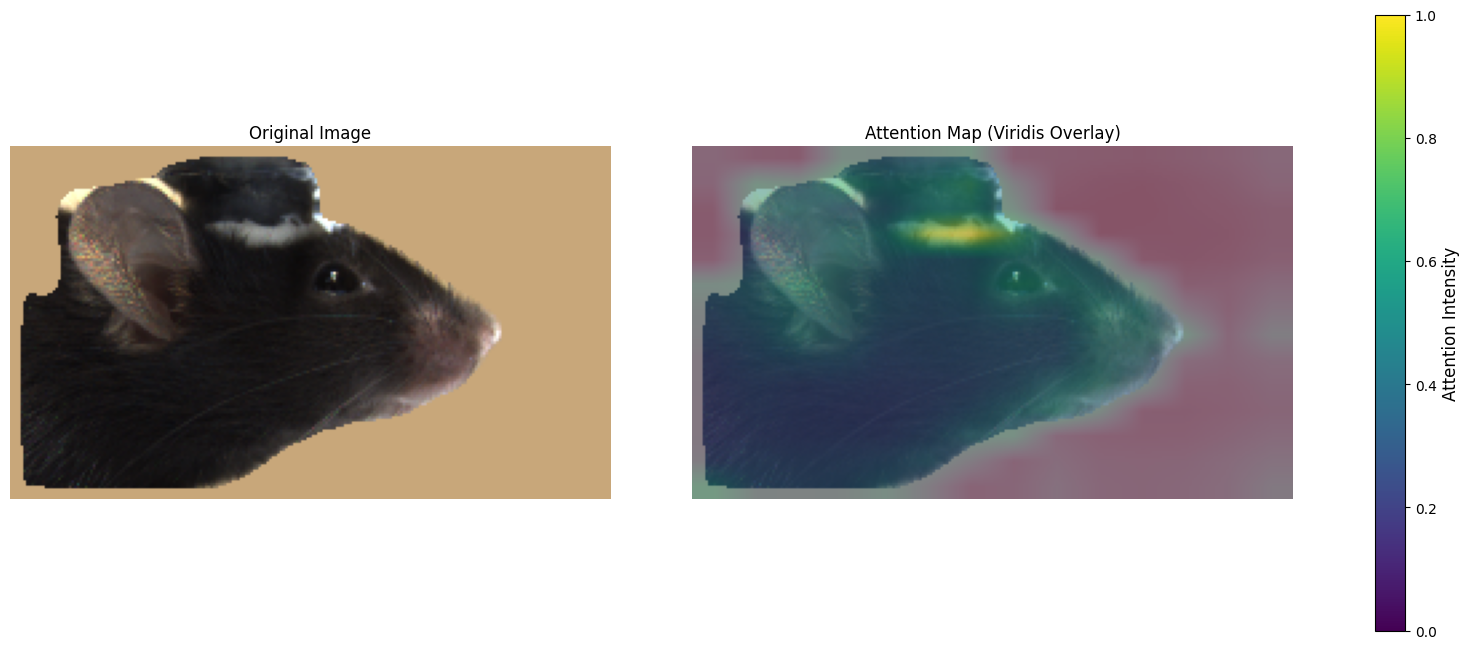

Prediction: Normal (Confidence: 0.99737)


In [11]:
import os
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms

from models.modeling import VisionTransformer, CONFIGS

# Load Your Trained Model
config = CONFIGS["ViT-B_16"]  # Ensure this matches your model type
num_classes = 3  # Your dataset has 3 classes: normal, pain, tickle
model_path = "output/test_checkpoint.bin"  # Change if necessary

# Initialize model
model = VisionTransformer(config, num_classes=num_classes, zero_head=True, img_size=224, vis=True)

# Load trained weights
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    print("✅ Model loaded successfully!")
else:
    raise FileNotFoundError(f"❌ Model checkpoint not found at {model_path}")

model.eval()

# Define Image Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Load an Image from Your Dataset
#test_img_path = r"C:\Users\avs20\Documents\GitHub\ViT-EmotionClassificationPytorch\data\normal\normal_0003.bmp"  # Change to a real image path
test_img_path = r"C:\Users\avs20\Documents\GitHub\ViT-EmotionClassificationPytorch\data\normal\normal_1000.bmp"
if not os.path.exists(test_img_path):
    raise FileNotFoundError(f"❌ Test image not found: {test_img_path}")

im = Image.open(test_img_path).convert("RGB")  # Ensure RGB format
x = transform(im).unsqueeze(0)

# Forward Pass Through Model
with torch.no_grad():
    logits, att_mat, cls = model(x)

# Compute Attention Matrices
att_mat = torch.stack(att_mat).squeeze(1)
att_mat = torch.mean(att_mat, dim=1)  # Average over heads

# Add identity matrix for residual connections
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Compute Joint Attention
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]
for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

# Extract Final Attention Map
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()

# Resize the attention map to match the image size
mask = cv2.resize(mask, im.size)

# Normalize the heatmap
mask = (mask - mask.min()) / (mask.max() - mask.min())

# Apply the Viridis colormap
heatmap = plt.cm.viridis(mask)[:, :, :3]  # Remove alpha channel

# Convert the original image to NumPy array
image_np = np.array(im) / 255.0  # Normalize to [0,1] for blending

# Blend heatmap and original image
alpha = 0.5  # Transparency level
overlay = (1 - alpha) * image_np + alpha * heatmap

# Display the results
fig, (ax1, ax2, cbar_ax) = plt.subplots(ncols=3, figsize=(18, 8), gridspec_kw={"width_ratios": [1, 1, 0.05]})

ax1.set_title('Original Image')
ax1.imshow(im)
ax1.axis("off")

ax2.set_title('Attention Map (Viridis Overlay)')
ax2.imshow(overlay)
ax2.axis("off")

# Add Color Scale (Legend)
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap="viridis"), cax=cbar_ax)
cbar.set_label("Attention Intensity", fontsize=12)

plt.show()

# Get Prediction
probs = torch.nn.Softmax(dim=-1)(logits)
predicted_class = torch.argmax(probs, dim=-1).item()

# Class Mapping (Adjust as Needed)
class_labels = {0: "Normal", 1: "Pain", 2: "Tickle"}

print(f"Prediction: {class_labels[predicted_class]} (Confidence: {probs[0, predicted_class]:.5f})")
